In [3]:
from elasticsearch import Elasticsearch
from elasticsearch import helpers
from elasticsearch_dsl import Search
import json
from pandasticsearch import Select
import sys
from pathlib import Path
import datetime
import time
import pandas as pd
import config as cfg
import numpy as np
# 일정기간 날짜 출력 방법
import datetime
from dateutil.relativedelta import relativedelta # datetime에 timedelta 모듈을 가져오는 라이브러리

#### ATHENA를 통해 방문수 데이터 다운
SELECT V2.nid, V2.visit, V2.newcategory, V2.rank						
FROM 						
   (SELECT V.*						
         , RANK() over (order by visit desc) as rank						
    FROM 						
       (SELECT nid, newcategory,count(*) as visit						
        FROM   elasticsearch_parquet						
        WHERE 1=1						
        AND  month = '06'						
        AND  type = 'VISIT'						
        AND  newcategory in ('CA0103')						
        AND  requestkey ='G9BUz12T'						
        GROUP BY nid, type,newcategory						
        ) V						
    )V2						
WHERE V2.rank <=10000						


In [4]:
# 기사리스트중에 방문수 정렬 상위 10000개 리스트
visit_df = pd.read_csv("캐시워크_CA0103_06.csv",encoding='utf-8-sig')
visit_df.head()

,nid,visit,newcategory,rank
0,2022061508455819371,39381,CA0103,1
1,2022061511133210794,37979,CA0103,2
2,2022063015453637013,32195,CA0103,3
3,2022062915342282686,30155,CA0103,4
4,2022061413143640747,29615,CA0103,5


In [5]:
visit_df.describe()

,nid,visit,rank
count,1.403000e+03,1403.000000,1403.000000
mean,2.022061e+18,5401.091946,699.396294
std,2.760330e+12,5790.315253,401.085282
min,2.022041e+18,1.000000,1.000000
25%,2.022061e+18,1849.500000,351.500000
50%,2.022062e+18,3922.000000,702.000000
75%,2.022062e+18,5725.000000,1052.500000
max,2.022063e+18,39381.000000,1322.000000


In [6]:
visit_df['nid']= visit_df['nid'].astype('str')

### 기사 테이블 가져오기

In [7]:
import pymysql
# 기사 제목,nid 가져오기
connect = pymysql.connect(host='ec2-3-35-194-202.ap-northeast-2.compute.amazonaws.com'
                        , port = 3306
                        , user='newspic_read'
                        , password ='shxlvmffjtm1!'
                        , db = 'newspic'
                        , charset='utf8')
# connection으로부터 cursor 생성
cur = connect.cursor()
# 수집 뉴스 테이블 picNews 가져오기
query_news = '''
            SELECT pn.author, nc.pcode, nc.codeName, TW.*
            FROM  picNews pn INNER JOIN newsCate nc        ON pn.category = nc.code 
                             INNER JOIN tbNewsTitleWord TW ON pn.nid = TW.nid
            WHERE 1=1 
            AND   pn.nid >= '2022021500000099999' 
            AND   pn.nid <= '2022063023595999999' 
            ORDER BY pn.pubDate DESC, pn.nid DESC
            '''
df_news = pd.read_sql(query_news, connect)
df_news = df_news[['nid','title','pcode','codeName','author','word','text_rank_word']]

In [8]:
nid_news2 = pd.merge(visit_df, df_news, on='nid')

In [9]:
top500= nid_news2.sort_values(by='visit',ascending = False).head(500)

In [10]:
top500.head()

,nid,visit,newcategory,rank,title,pcode,codeName,author,word,text_rank_word
0,2022061508455819371,39381,CA0103,1,이태원 40대 여배우 누구? 30대 남편에 자녀 1명 추측,CA03,연예 일반,국제뉴스,이태원 여배우 남편 자녀 추정,경찰 남편 남성 여배우 자녀
1,2022061511133210794,37979,CA0103,2,"""여보 미안해""… 생활비 문제로 남편 살해한 20대女, 구속 송치",CA01,사회일반,머니S,여보 미안 생활비 트러블 남편 살해 20대 구속 송치,구속 생활비 살해 여성 미안
2,2022063015453637013,32195,CA0103,3,조유나양 가족 뜻밖의 '부검결과' 나왔다,CA01,사건사고,경기연합신문,조유나양 가족 뜻밖 부검 결과,가족 결과 부검 검사 조유나양
3,2022062915342282686,30155,CA0103,4,"조유나 부모, 실종 직전까지 인터넷에 '추락'·'물때' 등 검색",CA01,사회일반,직썰,조유나 부모 실종 직전 인터넷 실추 물때 검색,경찰 가족 검색 조유나 부모
4,2022061413143640747,29615,CA0103,5,"달리는 차 앞 자전거로 막아버린 어린이 ""안 비켜"" 황당 영상에 누리꾼 분노",CA01,사회일반,살구뉴스,자전거 어린이 황당 영상 누리꾼 분노,자전거 어린이 영상 블랙박스 황당


In [11]:
top500 = top500[['title','nid','word','author','codeName','visit']]
top500.columns = ['title','nid','word','author','codeName','visit']

In [12]:
wordlist = top500['word'].str.split(" ",expand=True)
wordlist2 = wordlist.stack().reset_index(level=1, drop=True).to_frame('keyword')

In [13]:
df_top500 = top500.merge(wordlist2, left_index=True, right_index=True, how='left')

In [14]:
pivot2 = df_top500.groupby('keyword').count().sort_values(by='nid', ascending=False)

In [15]:
pivot500 = pd.pivot_table(df_top500 , index='keyword',values='visit',aggfunc=np.sum).sort_values(by='visit', ascending=False).head(100)
dict500 = pivot500.to_dict().get('visit')
pivot500= pivot500.reset_index()
pivot500.head(100)
#pivot500[pivot500[~isin['공개']]]

,keyword,visit
0,가족,495322
1,실종,429671
2,살해,317175
3,남편,285518
4,흉기,258852
...,...,...
95,갑질,59756
96,학대,59668
97,인터넷,59542
98,전국,59373


In [16]:
pivot = pd.merge(pivot500, pivot2, on='keyword')

In [17]:
pd.set_option('display.max_rows',10000)
pivot

,keyword,visit_x,title,nid,word,author,codeName,visit_y
0,가족,495322,40,40,40,40,40,40
1,실종,429671,34,34,34,34,34,34
2,살해,317175,22,22,22,22,22,22
3,남편,285518,15,15,15,15,15,15
4,흉기,258852,18,18,18,18,18,18
5,완도,244844,21,21,21,21,21,21
6,20대,235980,16,16,16,16,16,16
7,경찰,235865,26,26,26,26,26,26
8,발견,234297,19,19,19,19,19,19
9,아내,220286,15,15,15,15,15,15


In [18]:
pd.set_option('display.max_rows',10000)
news_df = pd.DataFrame()
for i in range(50):
    list = pivot500['keyword'].head(50)
    list3 = df_top500[df_top500['keyword'].isin([list[i]])].sort_values(['keyword','visit'], ascending=False).drop_duplicates('nid').head(10)
    news_df = news_df.append(list3)    
news_df

,title,nid,word,author,codeName,visit,keyword
2,조유나양 가족 뜻밖의 '부검결과' 나왔다,2022063015453637013,조유나양 가족 뜻밖 부검 결과,경기연합신문,사건사고,32195,가족
15,"'완도 일가족 실종' 조유나양 얼굴은 공개하고, 부모는 공개 안 한 이유",2022062715423311368,완도 가족 실종 조유나양 화상 공표 부모 공표 이유,로톡뉴스,사건사고,24986,가족
19,조유나 양 가족 승용차 바다 위로 인양…내부 확인 중,2022062912210927036,조유나 가족 자동차 바다 위로 내부 확인,연합뉴스,사회일반,24306,가족
24,"[영상] ""딸 자취방 몰래 들어와 샤워""…인터넷 달군 '카니발 가족'",2022062712025942780,자취방 샤워 인터넷 카니발 가족,연합뉴스,사회일반,23546,가족
44,"조유나양 가족, 실종 일주일전 수차례 완도 드나들어",2022062816032893932,조유나양 가족 실종 수차례 완도,더드라이브,사회일반,21180,가족
50,완도 실종 가족 차량 인양...유나양 시신 상태 공개되자 모두 오열했다,2022063013455652228,완도 실종 가족 차량 유나양 시체 상태 공표 오열,살구뉴스,정치일반,20503,가족
55,"물놀이 후 남의 집 몰래 들어가 샤워한 일가족 ""쓰레기까지 버려""",2022062614503255503,물놀 샤워 가족 쓰레기,머니S,사회일반,20149,가족
59,'완도 일가족 실종' 바다 추락가능성도...마지막 신호는?,2022062709525753398,완도 가족 실종 바다 실추 가능 마지막 신호,국제뉴스,사회일반,19742,가족
62,완도 실종 일가족은 어디에… 섬 안에 들어간 아우디도 행방불명,2022062613294585181,완도 실종 가족 아우디 행방불명,머니S,사회일반,19624,가족
90,"""물 뿌릴까?""… 골목서 담배 피우는 중학생에 골머리 앓는 가족",2022061813382706637,뿌릴 골목 담배 중학생 골머리 가족,머니S,사회일반,17948,가족


In [19]:
from wordcloud import WordCloud
from PIL import Image 
import matplotlib.pylab as plt #matplotlib파이썬에서 그래프를 그릴수 있는 라이브러리

cloud_image = "C:/Users/b/python/ttf/star.png"
icon = Image.open(cloud_image).convert("RGBA")
mask = Image.new("RGB", icon.size, (255,255,255))
mask.paste(icon,icon)
mask = np.array(mask)

wordcloud = WordCloud(
            font_path ="C:/Users/b/python/ttf/BMDOHYEON.ttf" 
            ,width = 500,height =500
            ,background_color ='white'
            ,colormap = 'magma' #ocean,magma
            ,random_state = 10
            ,mask = mask
            )

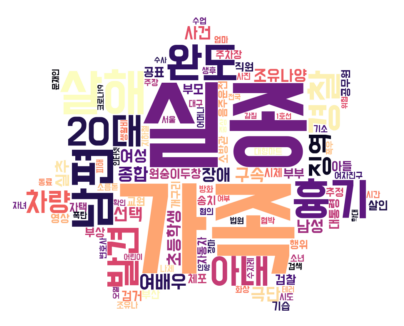

In [21]:
keyword =wordcloud.generate_from_frequencies(dict500 )
array = keyword.to_array()

plt.figure(figsize=(7,7)) # figure 사이즈 변경
plt.imshow(array, interpolation="bilinear") # imshow :이미지출력
plt.axis("off") # 축표시 생략
plt.show() #부가정보 출력 생략